# SIR model UPINN

In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('../../utils')
from DataGenerators import SIR

from upinn import UPINN
from architectures import FNN
from utils import SoftAdapt

In [10]:
X0 = [0.99, 0.01, 0.01, 0.0]

tbc = torch.tensor([0.0], dtype=torch.float32).reshape(-1, 1)
Xbc = torch.tensor(X0, dtype=torch.float32).reshape(1, -1)

beta = [0.3, 0.25]
gamma = [0.1, 0.1]

sir = SIR(beta, gamma, X0)

t = np.arange(0, 100, 7.0)
X = sir.solve(t)

td = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
Xd = torch.tensor(X, dtype=torch.float32)

tc = torch.linspace(0, 100, 1000).reshape(-1, 1)

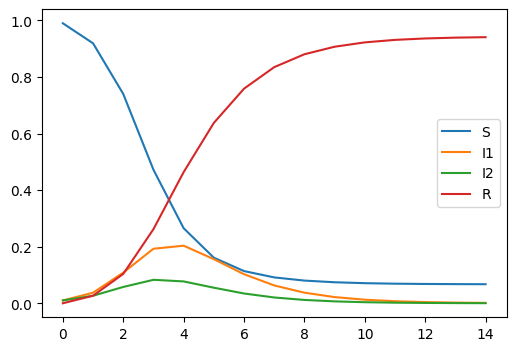

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(X[:, 0], label='S')
plt.plot(X[:, 1], label='I1')
plt.plot(X[:, 2], label='I2')
plt.plot(X[:, 3], label='R')
plt.legend()
plt.show()

In [12]:
class UPINN_SIR(UPINN):
    
    def pde_loss(self):
        if self.collocation_points is not None:
            U_c = self.u(self.collocation_points)
            res = self.F(self.F_input(self.collocation_points))
            pde_loss = torch.nn.MSELoss()(self.N(self.collocation_points, U_c), res) if self.collocation_points.shape[0] > 0 else torch.tensor(0.0)
        else: pde_loss = torch.tensor(0.0)
        return pde_loss
    
    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        # rows should sum to 1
        population_loss = torch.mean((self.u(self.collocation_points).sum(dim=1) - 1.0)**2)
        
        lambdas = SoftAdapt()([bc_loss, data_loss, pde_loss, population_loss])
        loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss + lambdas[3]*population_loss

        return loss, bc_loss, data_loss, pde_loss
    
    def data_loss(self):
        if self.data_points is not None:
            U_data = self.u(self.data_points[0]) 
            data_loss = torch.nn.MSELoss()(U_data[:, [0, 1, 3]], self.data_points[1][:, [0, 1, 3]])
        else: data_loss = torch.tensor(0.0)
        return data_loss
        

In [13]:
class SIR_model(torch.nn.Module):

    def __init__(self, beta1, gamma1):
        super(SIR_model, self).__init__()
        self.beta1 = beta1
        self.gamma1 = gamma1
    
    def forward(self, t, X):
        S, I1, I2, R = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

        dS = -self.beta1 * S * I1 - self.beta1 * S * I2
        dI1 = self.beta1 * S * I1 - self.gamma1 * I1
        dI2 = torch.zeros_like(t).squeeze(1)
        dR = self.gamma1 * I1 + self.gamma1 * I2

        return torch.stack([dS, dI1, dI2, dR], dim=1)

In [14]:
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 4],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.ReLU(),
)
F = FNN(
    dims=[4, *hidden, 4],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

N = SIR_model(beta[0], gamma[0])

model = UPINN(u, N, F, data_points=(td, Xd), collocation_points=tc, boundary_points=(tbc, Xbc))

[Info]: Initializing UPINN model


In [15]:
model.train_loop(10000)

[Info]: Training 10000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 10000/10000 [01:44<00:00, 95.29 epoch/s, L=1.39e-04, L_bc=5.00e-05, L_data=3.68e-04, L_pde=1.03e-07]


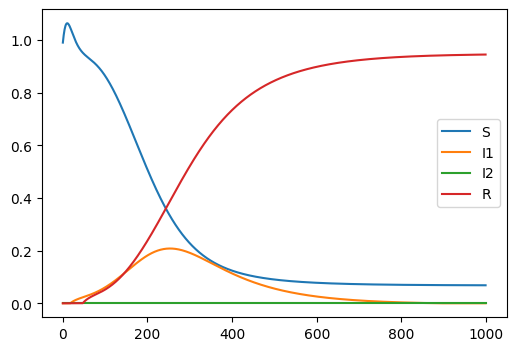

In [16]:
model.to('cpu')
X_pred = model.predict(tc)
X_pred = X_pred.detach().numpy()

plt.figure(figsize=(6, 4))
plt.plot(X_pred[:, 0], label='S')
plt.plot(X_pred[:, 1], label='I1')
plt.plot(X_pred[:, 2], label='I2')
plt.plot(X_pred[:, 3], label='R')
plt.legend()
plt.show()